In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import time
import multiprocessing
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [73]:
df_shanghai = pd.read_csv('sh_ershou_clean_v2.csv', index_col = 0)

In [74]:
print('df_shanghai.shape:{}'.format(df_shanghai.shape))

df_shanghai.shape:(14780, 11)


In [75]:
df_shanghai['year'] = df_shanghai['info'].str.extract('([\d]+)年').astype('float')
df_shanghai['age'] = 2022-df_shanghai.year

In [76]:
df_shanghai.drop(columns = ['longitude', 'dimension', 'year', 'latitude'], inplace = True)

In [77]:
df_shanghai.describe()

,total_price,unit_price,area,distance_rg,age
count,14780.000000,14780.000000,14780.000000,14778.000000,13498.000000
mean,514.321616,60010.600474,85.362117,16.297467,22.456068
std,520.297698,28833.133598,58.490598,13.757236,11.070863
min,36.000000,9743.000000,8.680000,0.000000,2.000000
25%,253.000000,38246.500000,51.907500,6.799799,14.000000
50%,385.000000,58976.500000,72.880000,11.817960,23.000000
75%,600.000000,77363.750000,101.985000,20.991488,28.000000
max,17800.000000,451777.000000,1547.730000,58.665046,111.000000


对上海数据进行聚类

In [78]:
# 对数值型数据进行标准化
t= preprocessing.StandardScaler().fit(df_shanghai[df_shanghai.describe().columns])
df_shanghai_processed = pd.DataFrame(t.transform(df_shanghai[df_shanghai.describe().columns]))
df_shanghai_processed.columns = df_shanghai.describe().columns

In [79]:
df_shanghai_processed.isna().sum(axis = 0)
# distance_rg、age存在缺失值

total_price       0
unit_price        0
area              0
distance_rg       2
age            1282
dtype: int64

In [80]:
# 缺失值填充
df_shanghai_processed.distance_rg.fillna(df_shanghai_processed.distance_rg.mean(), inplace = True)
df_shanghai_processed.age.fillna(df_shanghai_processed.age.mean(), inplace = True)

In [83]:
df_shanghai_processed = df_shanghai_processed[['unit_price', 'area', 'distance_rg', 'age']]

<AxesSubplot:>

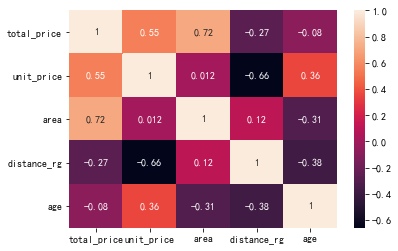

In [109]:
cor = df_shanghai[['total_price','unit_price', 'area', 'distance_rg', 'age']].corr()
sns.heatmap(cor, annot = True)
# 总体上来讲，建房时间越长，每平米价格越大（这块应该是因为建房时间长的总体上在比较市中心的地方）
# 建房时间越长，房屋面积越小、距离市中心越近

In [84]:
from sklearn.cluster import KMeans

In [85]:
# cate_index = [5] # 为类别型变量在columns中的索引
def TrainCluster(df, model_name=None, start_k=2, end_k=10):
    print('training cluster')
    K = []
    SSE = []
    silhouette_all=[]
    models = [] #保存每次的模型
    for i in range(start_k, end_k):
        start = time.perf_counter ()
        kmeans_model = KMeans(n_clusters=i, random_state=42)
        kmeans_model.fit(df_shanghai_processed)
        SSE.append(kmeans_model.inertia_)  # 保存每一个k值的SSE值
        K.append(i)
        print('{}-prototypes SSE loss = {}'.format(i, kmeans_model.inertia_))
        models.append(kmeans_model) #保存每个k值对应的模型
        end = time.perf_counter ()
        print('Running time: %s Seconds'%(end-start))

    return(K,SSE,models)

In [86]:
K, SSE, models = TrainCluster(df = df_shanghai_processed)

training cluster
2-prototypes SSE loss = 38756.82118472956
Running time: 0.13897300000007817 Seconds
3-prototypes SSE loss = 31722.011853689815
Running time: 1.184284899999966 Seconds
4-prototypes SSE loss = 26427.109726995204
Running time: 1.3466638999998395 Seconds
5-prototypes SSE loss = 22263.787385422133
Running time: 1.5923322000003282 Seconds
6-prototypes SSE loss = 19592.23811115553
Running time: 1.2175708000004306 Seconds
7-prototypes SSE loss = 18044.306957421984
Running time: 1.1350750999999946 Seconds
8-prototypes SSE loss = 16520.98267815307
Running time: 1.6721833999999944 Seconds
9-prototypes SSE loss = 15010.894801808301
Running time: 4.4716590000002725 Seconds


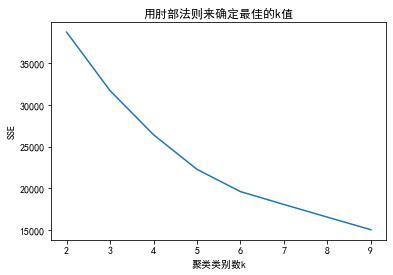

In [87]:
# 决定选择5
plt.plot(K, SSE)
plt.xlabel('聚类类别数k')
plt.ylabel('SSE')
plt.xticks(K)
plt.title('用肘部法则来确定最佳的k值')
plt.show()

In [170]:
#确定了最佳的k值后：5
best_model = models[K.index(5)]

In [171]:
df_shanghai['labels_'] = best_model.labels_

In [172]:
center = pd.DataFrame(best_model.cluster_centers_ )
center.columns = df_shanghai_processed.columns

In [173]:
# 添加原始值
for col in center.columns:
    col_new = col+'_raw'
    mean = df_shanghai[col].mean()
    std = df_shanghai[col].std()
    center[col_new] = center[col]*std+mean
    print(col_new)

unit_price_raw
area_raw
distance_rg_raw
age_raw


In [179]:
df_shanghai.labels_.value_counts()

4    5216
0    4466
1    2660
2    2279
3     159
Name: labels_, dtype: int64

In [174]:
center
# 0 4466 看起来性价比高些：地理位置也不太远、4-6万、户型也不是太大、离人民广场10-25公里的居多
# 1 2660 市中心大户型
# 2 2279 郊区大户型, 单价不是太高
# 3 159 面积有点太大了吧,简单看了下好多5室6室的房子
# 4 5216 市中心老破小

,unit_price,area,distance_rg,age,unit_price_raw,area_raw,distance_rg_raw,age_raw
0,-0.556648,-0.107209,0.027553,-0.555107,43960.686043,79.091386,16.676518,16.310559
1,0.988883,0.683625,-0.556500,-0.324163,88523.206883,125.347739,8.641572,18.867302
2,-1.251000,0.194375,1.948933,-0.543748,23940.356310,96.731223,43.109403,16.436313
3,0.162400,6.041725,0.157349,-0.761968,64693.114385,438.746232,18.462155,14.020424
4,0.513974,-0.526476,-0.596262,0.902155,74830.085653,54.568210,8.094549,32.443707


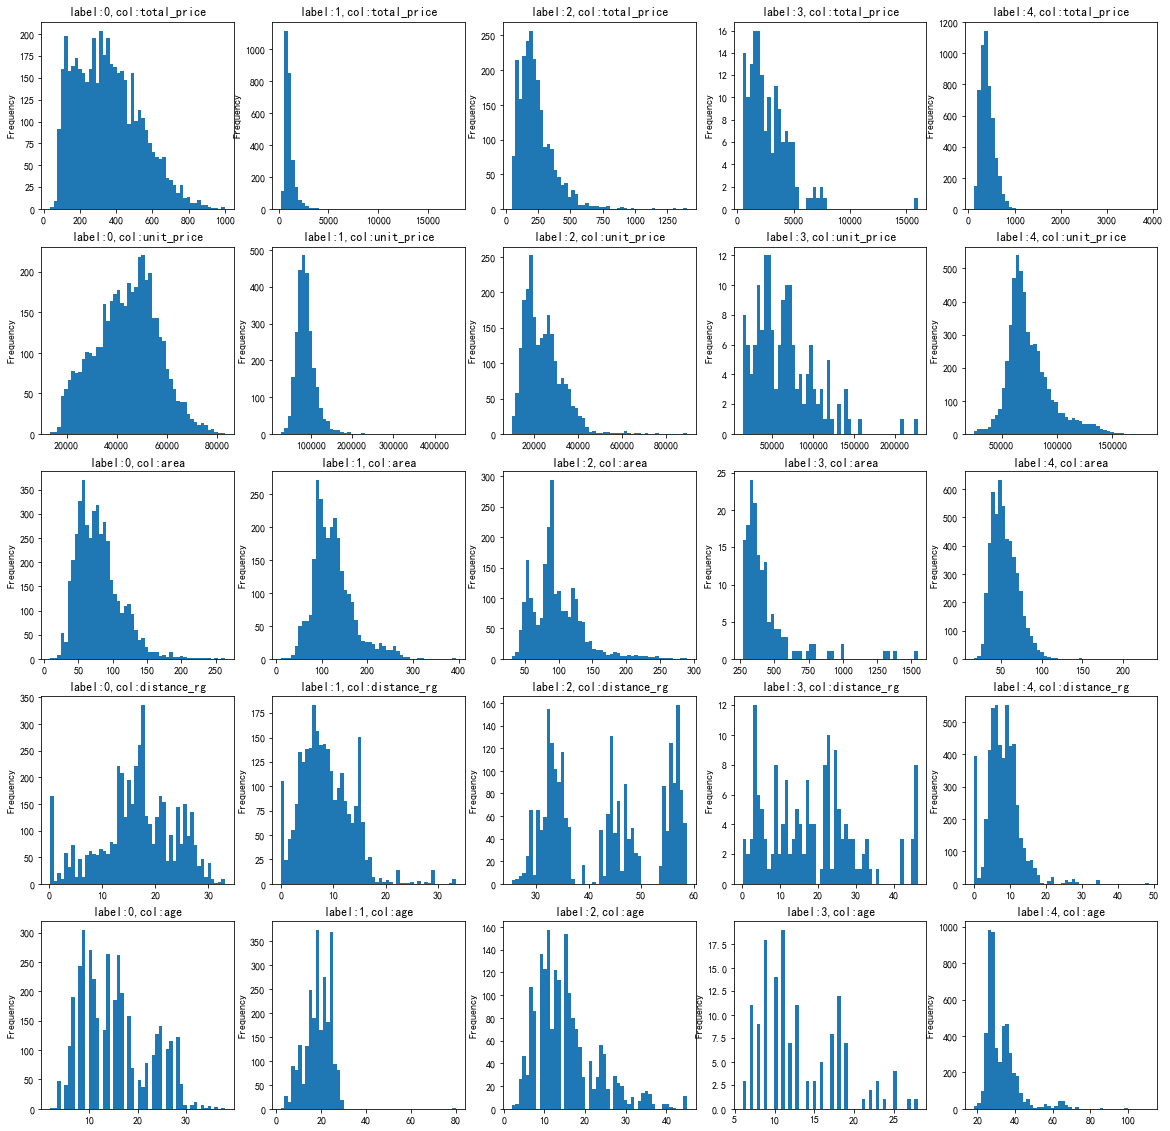

In [183]:
# 聚类后按类别对各个column绘制分布图
col = ['total_price',  'unit_price', 'area', 'distance_rg', 'age']
fig = plt.figure(figsize = (20,20))
n_col = len(col)
n_labels = 5
for i in range(n_col): #特征个数
    for j in range(n_labels): # 类别个数
        ax = fig.add_subplot(n_col, n_labels, n_labels*i+j+1)
        df_shanghai.loc[df_shanghai.labels_ == j, col[i]].plot(kind = 'hist', bins = 50)
        ax.set_title('label:{},col:{}'.format(j, col[i]))
#         if col[i] == 'unit_price':
#             ax.set_xlim(0, max(df_shanghai.unit_price))
#         if col[i] == 'area':
#             ax.set_xlim(0, max(df_shanghai.area))
#         if col[i] == 'distance_rg':
#             ax.set_xlim(0, max(df_shanghai.distance_rg))
#         if col[i] == 'age':
#             ax.set_xlim(0, max(df_shanghai.age))
plt.show()

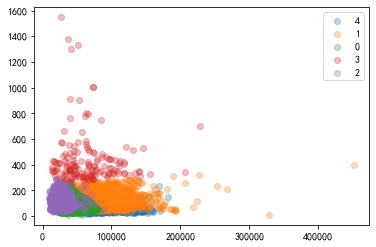

In [126]:
# 绘制散点图
colors1 = '#00CED1' #点的颜色
colors2 = '#DC143C'

col1 = 'unit_price'
col2 = 'area'

for label in df_shanghai.labels_.unique():
#     if label != 3:
    if True:
        x = df_shanghai.loc[df_shanghai.labels_ == label, col1]
        y = df_shanghai.loc[df_shanghai.labels_ == label, col2]
        plt.scatter(x, y, label = str(label), alpha = 0.3)

plt.legend()